In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt


DEVICE = torch.device("cpu")

# --- Path config ---
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(),"..", "..", "data", "auto_vi", "pipe_staple", "pipe_staple"))

print(f"Data root directory: {BASE_DIR}")

# Hyperparameters
IMG_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 10

Data root directory: /home/antoine/upb/aifortdm/data/auto_vi/pipe_staple/pipe_staple


In [2]:
def prepare_file_list(base_dir):
    """
    Traverse the specific directory structure to retrieve:
    - Label 0 (Good) : train/good + test/good
    - Label 1 (Bad)  : test/missing (or other defect folders)
    """
    image_paths = []
    labels = []
    
    # 1. Get "good" image (label 0)
    good_paths = glob.glob(os.path.join(base_dir, "train", "good", "*.png")) + \
                 glob.glob(os.path.join(base_dir, "test", "good", "*.png"))
    
    for p in good_paths:
        image_paths.append(p)
        labels.append(0) 
        
    # 2. Get "defect" images (label 1)
    defect_paths = glob.glob(os.path.join(base_dir, "test", "missing", "*.png"))
    

    for p in defect_paths:
        image_paths.append(p)
        labels.append(1)
        
    print(f"Total images 'Good' (0): {labels.count(0)}")
    print(f"Total images 'Defect' (1): {labels.count(1)}")
    
    return np.array(image_paths), np.array(labels)


all_paths, all_labels = prepare_file_list(BASE_DIR)

X_train, X_test, y_train, y_test = train_test_split(
    all_paths, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"Train size: {len(X_train)}")
print(f"Test size : {len(X_test)}")

Total images 'Good' (0): 379
Total images 'Defect' (1): 117
Train size: 396
Test size : 100


In [3]:
class IndustrialDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = IndustrialDataset(X_train, y_train, transform=data_transform)
test_dataset = IndustrialDataset(X_test, y_test, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolution 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2) 
        
        # Convolution 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2) 
        
        # Convolution 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2) 
        
        # Fully Connected
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2) # 2 classes (Good/Bad)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(DEVICE)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
test_accs = []

print("--- Start of training (Centralized) ---")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Quick evaluation at the end of the epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_acc = 100 * correct / total
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    test_accs.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss:.4f} | Test Acc: {epoch_acc:.2f}%")

print("--- Training finished ---")


torch.save(model.state_dict(), "centralized_model.pth")

--- Start of training (Centralized) ---
Epoch 1/10 | Loss: 0.6036 | Test Acc: 76.00%
Epoch 2/10 | Loss: 0.3962 | Test Acc: 98.00%
Epoch 3/10 | Loss: 0.0657 | Test Acc: 99.00%
Epoch 4/10 | Loss: 0.0506 | Test Acc: 100.00%
Epoch 5/10 | Loss: 0.0233 | Test Acc: 100.00%
Epoch 6/10 | Loss: 0.0353 | Test Acc: 100.00%
Epoch 7/10 | Loss: 0.0188 | Test Acc: 100.00%
Epoch 8/10 | Loss: 0.0137 | Test Acc: 100.00%
Epoch 9/10 | Loss: 0.0033 | Test Acc: 100.00%
Epoch 10/10 | Loss: 0.0099 | Test Acc: 100.00%
--- Training finished ---



--- Detailed Report ---
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00        76
      Defect       1.00      1.00      1.00        24

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



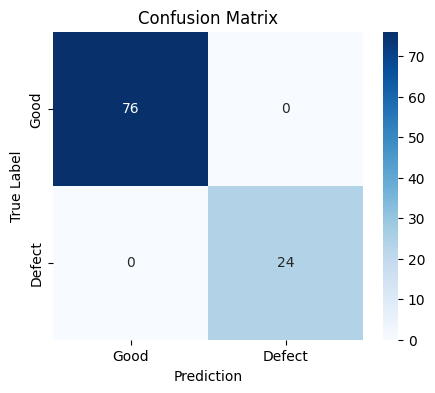

AUC Score: 1.0000


In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns


model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        
        probs = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 1. Detailed Report
print("\n--- Detailed Report ---")
print(classification_report(all_labels, all_preds, target_names=["Good", "Defect"]))

# 2. Confusion Matrix 
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Good", "Defect"], yticklabels=["Good", "Defect"])
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 3. AUC Score 
try:
    auc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])
    print(f"AUC Score: {auc:.4f}")
except Exception as e:
    print(f"AUC Error: {e}")

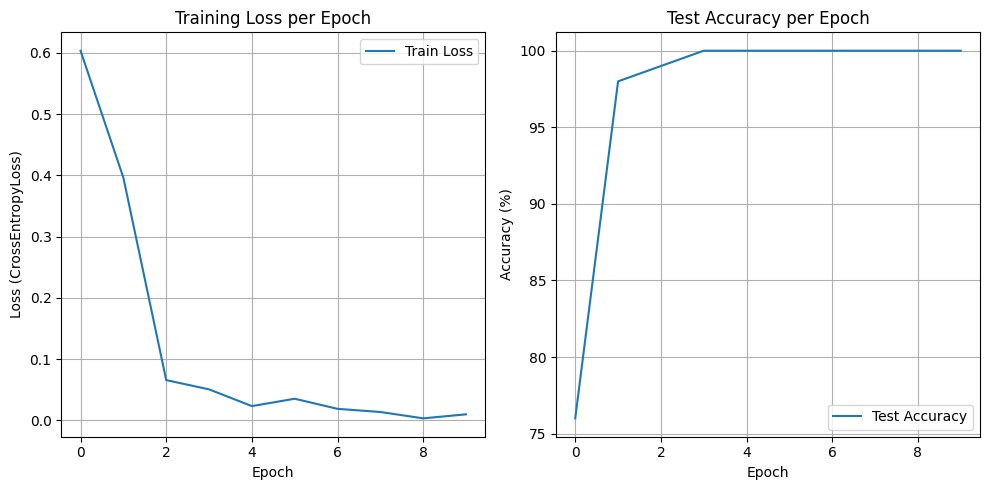

Final Accuracy: 100.00%


In [7]:
plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss (CrossEntropyLoss)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(test_accs, label='Test Accuracy')
plt.title("Test Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Final Accuracy: {test_accs[-1]:.2f}%")